In [1]:
import pandas as pd 
import numpy as np
import re       
import string   
import nltk
import math

import matplotlib.pyplot as plt

from wordcloud import WordCloud # importo la funcion WordCloud

# Objetos de sklearn para hacer tópicos
from sklearn.feature_extraction.text import CountVectorizer # Contador de frecuencia
from sklearn.feature_extraction.text import TfidfTransformer # Creador de tf-idf

# Algoritmos de descomposición de tópicos
from sklearn.decomposition import NMF 
from sklearn.decomposition import LatentDirichletAllocation

import multiprocessing
from gensim.models import Word2Vec

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [19]:
#%%DATAFRAMES
ep_count = [1, 7, 31, 47, 69, 91, 111, 123]
episodes_list = []
for i in range(1,8):
    for j in range(1,ep_count[i]-ep_count[i-1]+1):
        if j<10:
            episodes_list.append(pd.read_csv('https://raw.githubusercontent.com/brobbio/parks_and_rec/master/scripts/s'+str(i)+'e0'+str(j)+'.csv'))
        else:
            episodes_list.append(pd.read_csv('https://raw.githubusercontent.com/brobbio/parks_and_rec/master/scripts/s'+str(i)+'e'+str(j)+'.csv'))
#Breakdown by season -- puede ser innecesario?
df_s1_list = episodes_list[0:6]
df_s2_list = episodes_list[6:30]
df_s3_list = episodes_list[30:46]
df_s4_list = episodes_list[46:68]
df_s5_list = episodes_list[68:90]
df_s6_list = episodes_list[90:110]
df_s7_list = episodes_list[110:123]

df_all = pd.concat(episodes_list)

df_seasons = [pd.concat(df_s1_list), pd.concat(df_s2_list), pd.concat(df_s3_list), pd.concat(df_s4_list),
               pd.concat(df_s5_list), pd.concat(df_s6_list), pd.concat(df_s7_list)]

main_characters = df_all['Character'].value_counts()[:7].index.tolist()

#Fix an error in the dataframe:
df_all['Character'].iloc[1981] = "Leslie Knope"

In [4]:
#%% FUNCIONES
def clean_text(text):
    text = text.lower()                                              
    text = re.sub('\[.*?¿\]\%', ' ', text)                           
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) 
    text = re.sub('\w*\d\w*', '', text)   
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    return text

clean = lambda x: clean_text(x)

def remove_sw(text):
  words = text.split(' ') # separamos por espacios
  words_clean = []
  for w in words:
    if not w in Stopwords: 
      words_clean.append(w)
  return ' '.join(words_clean)

clean2 = lambda x: remove_sw(x)

def isNaN(num):
    return num != num

def isCharacter(df, nombre, thres):
  lista = list(df['Character'])
  return lista.count(nombre)> thres



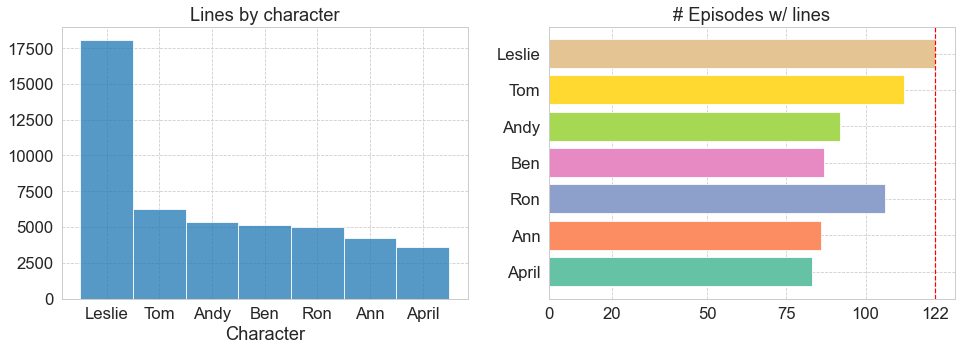

In [20]:
df = pd.concat([df_all[df_all['Character']== name] for name in main_characters])
sns.set_context("paper", font_scale = 1.9,) 
sns.set_style("whitegrid",rc = {'grid.linestyle': '--'})

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))
sns.histplot(ax = axs[0], data = df['Character'], stat="count", discrete = True)
axs[0].set_title('Lines by character')
axs[0].set_xticks(np.asarray([i for i in range(len(main_characters))]))
axs[0].set_xlabel('Character')
axs[0].set_ylabel('')
axs[0].set_xticklabels(["Leslie", "Tom", "Andy", "Ben", "Ron", "Ann", "April"], rotation=0)

axs[1] = plt.barh(["Leslie", "Tom", "Andy", "Ben", "Ron", "Ann", "April"][::-1], [sum([isCharacter(df, name, 20) for df in 
                                           episodes_list]) for name in main_characters][::-1], color = plt.get_cmap('Set2').colors)
plt.axvline(x=122, color='r', linestyle='--')
plt.title('# Episodes w/ lines')
plt.xticks([0, 20, 50, 75, 100, 122])
plt.show()


NameError: name 'ep_nbr' is not defined

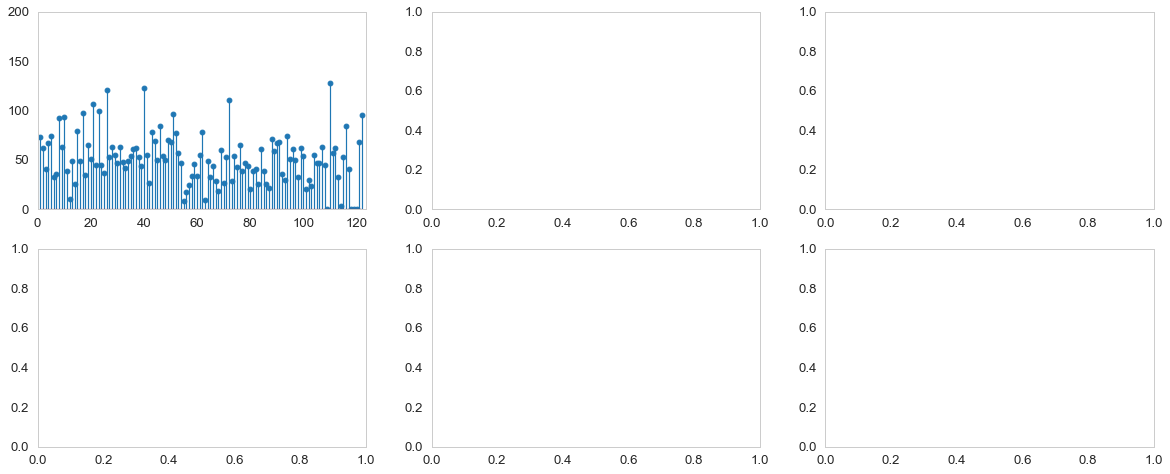

In [21]:
sns.set_context("paper", font_scale = 1.5,) 
sns.set_style("whitegrid",rc = {'grid.linestyle': ''})
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (20,8))
characters = ['Tom Haverford', 'Andy Dwyer', 'Ben Wyatt', 'Ron Swanson', 'Ann Perkins', 'April Ludgate']

for name in characters:
    i = characters.index(name)
    j = math.floor(i/3)
    i = i -3*j
    x = list(range(1,123))
    y = [len(list(df[df['Character'] == name]['Character'])) for df in episodes_list]
    axs[j,i].stem(x, y)
    axs[j,i].axis([0, 123.5, 0, 200])
    for k in range(1,7):
        axs[j,i].axvline(x= ep_nbr[k], color='r', linestyle='dotted')
    for k in range(7):
        axs[j,i].hlines(y=np.mean([len(list(df[df['Character']==name]['Character'])) for 
                                   df in episodes_list[ep_count[k]-1:ep_nbr[k+1]-1]]), 
                        xmin= ep_count[k], xmax= ep_count[k+1], linewidth=2, color='g', linestyle = '--')
    axs[j,i].set_xticks([1, 7, 31, 47, 69, 91, 111])
    axs[j,i].set_title(name, color = 'navy')
    axs[j,i].set_xticklabels(["1","2", "3", "4", "5","6","7"])
    axs[1,i].set_xlabel('Season')
    axs[j,0].set_ylabel('# Lines')
    
    
plt.show()


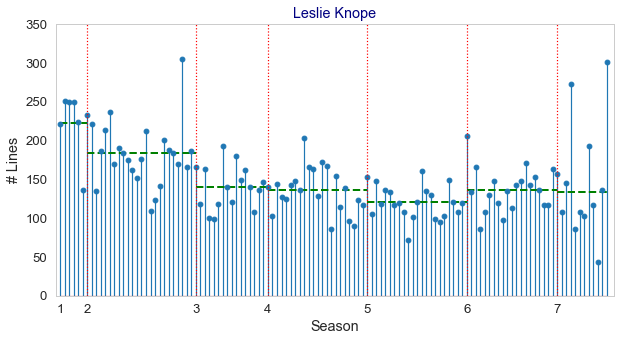

In [19]:
fig, ax = plt.subplots(figsize = (10,5))
name = "Leslie Knope"

x =list(range(1,123))
y=[len(list(df[df['Character']==name]['Character'])) for df in episodes_list]
plt.stem(x, y)
plt.axis([0, 123.5, 0, 350])
for k in range(1,7):
    plt.axvline(x= episode_number[k], color='r', linestyle='dotted')
for k in range(7):
    ax.hlines(y=np.mean([len(list(df[df['Character']==name]['Character'])) for df 
                             in episodes_list[ep_count[k]-1:ep_count[k+1]-1]]), 
                        xmin= ep_count[k], xmax=ep_count[k+1], linewidth=2, color='g', linestyle = '--')
plt.xticks([1, 7, 31, 47, 69, 91, 111], labels=["1","2", "3", "4", "5","6","7"])
plt.xlabel('Season')
plt.ylabel('# Lines')
plt.title(name, color = 'navy')
plt.show()

In [22]:
#%%STOPWORDS
import requests

r = requests.get('https://raw.githubusercontent.com/brobbio/parks_and_rec/master/stopwords-en.txt')

Stopwords = r.text.strip().split('\n')

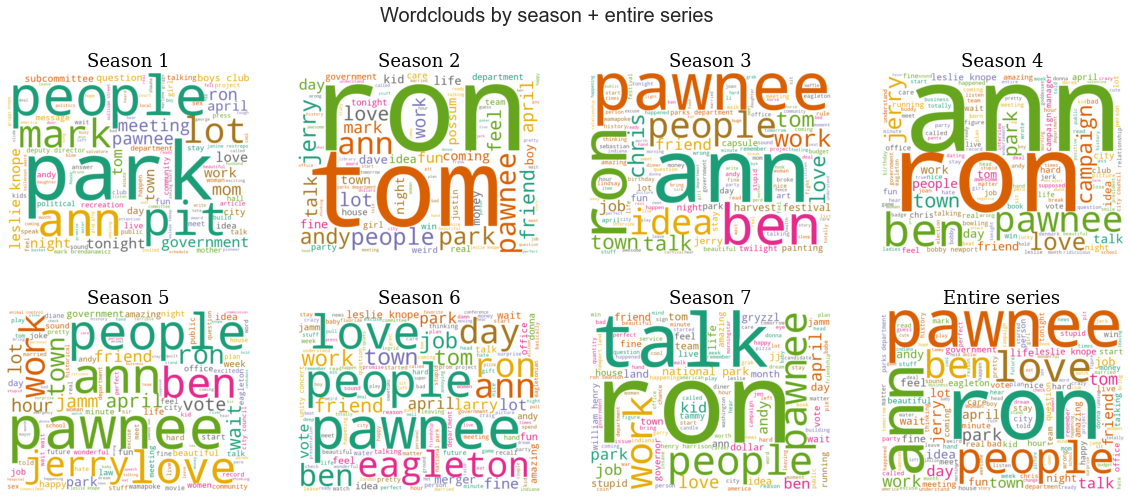

In [23]:
#%%WORDCLOUDS POR TEMPORADAS

char_name = "Leslie Knope"

dataframes_character = [df[df['Character']== char_name] for df in df_seasons]
dataframes_character.append(df_all[df_all['Character'] == char_name])

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 25,
        }

fig, axs = plt.subplots(2, 4, figsize = (20,8))
fig.suptitle('Wordclouds by season + entire series', fontsize = 20)

for i in range(0,8):   
    df = dataframes_character[i]
    j = math.floor(i/4)
    i = i -4*j
    df_clean = pd.DataFrame(df['Line'].apply(clean))
    
    modified = []
    for e in df_clean['Line']:
        modified.append(re.sub(r"\([^()]*\)", "", e))
    df_clean['Line'] = modified
    
    transcript = ''
    for t in df_clean['Line']:
        transcript = transcript + t

    wc = WordCloud(width=800, height=600, stopwords=Stopwords, background_color="white", colormap="Dark2",
                  min_font_size=12, random_state=42)
    wc.generate(transcript)
    axs[j,i].imshow(wc, interpolation="bilinear")  
    axs[j,i].axis("off")
    if i+4*j+1 == 8:
        axs[j,i].set_title("Entire series", fontdict=font, fontsize = 18)
    else:
        axs[j,i].set_title("Season "+ str(i+4*j+1), fontdict=font, fontsize = 18)

plt.show()

Word2Vec: 
We start by creating a new dataframe that has as entries the whole text of each episode. 

In [6]:
df_text = pd.DataFrame(index = list(range(0,121)), columns = ['Text'])

df_text['Text'] = [df['Line'].str.cat(sep = ' ') for df in episodes_list]

In [7]:
#%%WORD2VEC using the text by episode

df_clean = pd.DataFrame(df_text['Text'].apply(clean))
 
df_clean =  pd.DataFrame(df_clean['Text'].apply(clean2))

sentences = [row.split() for row in df_clean['Text']]

cores = multiprocessing.cpu_count()

w2v_model = Word2Vec(min_count=15, # ignora palabras cuya frecuencia es menor a esta
                     window=2, # tamanio de la ventana de contexto
                     size=50, # dimension del embedding
                     sample=6e-5, # umbral para downsamplear palabras muy frecuentes
                     alpha=0.03, # tasa de aprendizaje inicial (entrenamiento de la red neuronal)
                     min_alpha=0.0007, # tasa de aprendizaje minima
                     negative=10, # penalidad de palabras muy frecuentes o poco informaitvas
                     workers=cores) # numero de cores para entrenar el modelo

w2v_model.build_vocab(sentences, progress_per=10000) # construye el vocabulario

### ENTRENA EL MODELO
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
### PRECOMPUTA DISTANCIAS (mas rapido)
w2v_model.init_sims(replace=True)


In [9]:
import sys
all_sims = w2v_model.wv.most_similar(positive = ["andy"], topn=sys.maxsize)
last_10 = list(reversed(all_sims[-10:]))
print(last_10)


[('grid', 0.5467928647994995), ('chop', 0.5584807991981506), ('kick', 0.6134746074676514), ('poker', 0.6639278531074524), ('bounce', 0.7086724638938904), ('ginuwine', 0.7795521020889282), ('dig', 0.8710355758666992), ('bobby', 0.8866685032844543), ('henry', 0.8966841697692871), ('karate', 0.9000411033630371)]


In [11]:
for e in w2v_model.wv.most_similar(positive=["andy"], topn = 5): 
    print(e)
    print("\n")

('dwyer', 0.998563289642334)


('play', 0.9976778030395508)


('sweetheart', 0.9976663589477539)


('playing', 0.9976553916931152)


('minutes', 0.9976404309272766)




Poniendo todo el texto al menos da las primeras dos palabras de manera razonable

In [16]:
#%%% DEFINICION SCATTERPLOT
def tsnescatterplot(model, word, list_names):

    arrays = np.empty((0, 50), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    close_words = model.wv.most_similar([word])
    
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    sns.set_context("paper", font_scale = 1.9,) 
    sns.set_style("whitegrid",rc = {'grid.linestyle': '--'})
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE de {}'.format(word.title()))

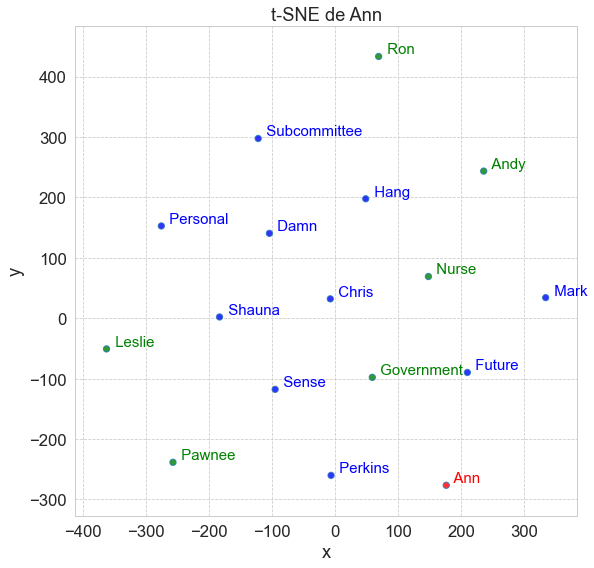

In [17]:
#%%SCATTER PLOT
tsnescatterplot(w2v_model, 'ann', ['leslie', 'andy', 'ron', 'government', 'pawnee', 'nurse'])


#Análisis de tópicos

In [21]:
#%%ANALISIS DE TOPICOS

Stopwords = Stopwords + ['ain', 'hadn', 'mightn', 'mustn', 'needn', 'shan']

count = CountVectorizer(min_df = 3, max_df = 0.75, stop_words = Stopwords)

# Ajustamos con los datos. Acá especificamente creamos una matriz documentos-términos
x_count = count.fit_transform(df_text['Text'])

# Creamos el objeto tf-idf. Le decimos además que devuelva los
# vectores documento con norma euclídea igual a 1 (norm = 'l2')
tfidf = TfidfTransformer(norm = 'l2')

# Creamos la matriz tf-idf a partir de la matriz de frecuencias
x_tfidf = tfidf.fit_transform(x_count)

# Elijamos la cantidad de tópicos
n_components = 7

# Construímos el objeto NMF con los tópicos indicados 
nmf = NMF(n_components = n_components)

# Aplicamos sobre nuestros datos
x_nmf = nmf.fit_transform(x_tfidf)

# Dimensión de la matriz transformada
#print(x_nmf.shape)

# Objeto índice: término de nuestro vocabulario
vocabulary = {item: key for key, item in count.vocabulary_.items()}

for n in range(n_components):

  # Ordenamos una lista del largo de nuestro vocabulario según el peso en cada componente y nos quedamos con los primeros 10
  list_sorted = sorted(range(nmf.components_.shape[1]), reverse = True, key = lambda x: nmf.components_[n][x])[:10]

  # Printeamos los términos asociados a los valores más grande de cada una de las componentes
  print(', '.join([vocabulary[i] for i in list_sorted]))
  print('\n')

jerry, chris, party, night, office, married, jamm, bad, government, tonight


newport, bobby, campaign, vote, vans, win, barkley, manager, debate, council


pit, park, mark, fell, parks, government, subcommittee, brendanawicz, meeting, department


eagleton, larry, merger, birthday, fence, concert, unity, eagletonians, craig, recall


tammy, library, vote, jamm, diane, swanson, gold, baby, jello, jail


gryzzl, karate, johnny, land, national, jj, yo, terry, kids, newport


justin, frank, valentine, marlene, mark, mom, gay, assistant, teachers, center




Aca los topicos 2, 3, 5 y 7 son bastante razonables mientras que 1 es cualquiera y 6 tiene algunas palabras bien conectadas (justin, frank, valentine, marlene, mom) mientras que las demas son bastante fruta

#Emociones

In [30]:
def talksAbout(sentence, words):
  return set(words.split()).issubset(set(sentence.split()))

In [6]:
import nltk # En este caso, únicamente para stopwords
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nati/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
#CAMBIOS EN EL DATAFRAME
lista_ann = [17388, 52371,54618,54827, 15554, 30541, 9755, 10267, 19632, 22844, 36472, 54352,
             20193, 29272, 39191, 39592, 42512, 42535, 56726]

lista_ben = [31418, 32555,35274,35374,35710,36847, 50238,
             38797, 39406, 39820, 43000,44037, 50240,51189,51562,54251,55095]

df_all['Line'].iloc[lista_ann] = "(Ann) "+ df_all['Line'].iloc[lista_ann]

df_all['Line'].iloc[lista_ben] = "(Ben) " + df_all['Line'].iloc[lista_ben]

df_all['Line'].iloc[[40317, 63301,63434,41831 , 45773]] = "(April) "+ df_all['Line'].iloc[[40317, 63301,63434,41831 , 45773]]

df_all['Line'].iloc[[48839, 49934]] = "(Pawnee)" + df_all['Line'].iloc[[48839, 49934]]

df_all['Line'].iloc[57314] = "(Ron) " + df_all['Line'].iloc[57314]

df_all['Line'].iloc[58965] = "(April Andy) " + df_all['Line'].iloc[58965]



In [58]:
#First, we take the names of the characters that have 100 or more lines of dialogue in the entire series:
characters = [name for name in list(set(list(df_all['Character']))) if isCharacter(df_all, name, 100)]

#Now we stick with only their first name (rarely we will find that Leslie refers to anyone by name + last name):
names = [str(n).split(' ')[0] for n in characters]
names = list(set(names))

#We remove the innecessary info that we end up with: 
names.remove('Extra')
names.remove('The')
names.remove('Dr.')
names.remove('Jerry')

#We lower case everything we our clean_text function: 
names = list(map(clean_text, names))

#
df_Leslie = df_all[df_all['Character']=='Leslie Knope']
scores = []
df_clean = pd.DataFrame(df_Leslie['Line'].apply(clean_text))

for name in names + ['pawnee', 'waffles', 'jamm']: 

    #We create a new dataframe with only the lines where Leslie mentions the character or thing in question
    df = df_Leslie[df_clean['Line'].map(lambda line: talksAbout(line, name))] 
    
    #We create a list of scores: each entry corresponds to one line of dialogue.
    scores_all = [sia.polarity_scores(str(list(df['Line'])[i])) for i in range(len(list(df['Line'])))]

    #Some phrases are repeated (ex 'thanks Ann') so create a list with only *unique* lines of dialogue.
    scores_unique = [sia.polarity_scores(str(list(dict.fromkeys(df['Line']))[i])) for i in 
                                                             range(len(list(dict.fromkeys(df['Line']))))]
    
    #Each entry of scores has four keys: 'pos', 'neg', 'neu' and 'compound'. We take out those lines of dialogue
    #that do not give too much info about the sentiment, the 'neutral' ones. 
    scores_non_neu = [d for d in scores_all if d['neu']<0.75]

    #We keep the negative entry of the scores, get the mean (testing how negatively Leslie speaks of this item)
    # and we keep track of the 5 most negative lines. 
    scores_neg = [scores_unique[i]['neg'] for i in range(len(scores_unique))]
    mean_neg = np.mean(scores_neg)
    top_neg = sorted(range(len(scores_neg)), key=lambda i: scores_neg[i], reverse=True)[:5]

    #We repeat with the positive part of the scores. 
    scores_pos = [scores_unique[i]['pos'] for i in range(len(scores_unique))]
    mean_pos = np.mean(scores_pos)
    top_pos = sorted(range(len(scores_pos)), key=lambda i: scores_pos[i], reverse=True)[:5]
    
    if len(scores_non_neu) > 20:
        if name == 'jamm':
            print(name)
            for i in range(len(top_neg)): 
                print(list(dict.fromkeys(df['Line']))[top_neg[i]])
                print(sia.polarity_scores(list(dict.fromkeys(df['Line']))[top_neg[i]]))
            print("\n")
        else:
            print(name)
            for i in range(len(top_pos)): 
                print(list(dict.fromkeys(df['Line']))[top_pos[i]])
                print(sia.polarity_scores(list(dict.fromkeys(df['Line']))[top_pos[i]]))
            print("\n")

        scores.append((name ,np.mean([scores_non_neu[i]['compound'] for i in range(len(scores_non_neu))])))

print(scores)

april
Please, April!
{'neg': 0.0, 'neu': 0.278, 'pos': 0.722, 'compound': 0.3802}
I agree, April.
{'neg': 0.0, 'neu': 0.286, 'pos': 0.714, 'compound': 0.3612}
That's great, April.
{'neg': 0.0, 'neu': 0.328, 'pos': 0.672, 'compound': 0.6249}
Okay, April.
{'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'compound': 0.2263}
April had the best idea, and today the best idea won.
{'neg': 0.0, 'neu': 0.398, 'pos': 0.602, 'compound': 0.9201}


andy
Andy, please.
{'neg': 0.0, 'neu': 0.303, 'pos': 0.697, 'compound': 0.3182}
Okay, Andy.
{'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'compound': 0.2263}
I love April and Andy.
{'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.6369}
Thank you, Andy.
{'neg': 0.0, 'neu': 0.444, 'pos': 0.556, 'compound': 0.3612}
Andy, thank you.
{'neg': 0.0, 'neu': 0.444, 'pos': 0.556, 'compound': 0.3612}


ben
Yay, Ben!
{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5707}
Yay! Fun Ben lives.
{'neg': 0.0, 'neu': 0.222, 'pos': 0.778, 'compound': 0.7901}
Ben, he's winning

In [ ]:
lista = ["eagleton", "eagletonian", "eagletonians"]

df = pd.concat([df_Leslie[df_clean['Line'].map(lambda oracion: hablaDe(oracion, nombre))] for nombre in lista])

lista_dic_total = [sia.polarity_scores(str(list(df['Line'])[i])) for i in range(len(list(df['Line'])))]

lista_noneutral = [d for d in lista_dic_total if d['neu']<0.75]

lista_neg = [lista_dic_unique[i]['neg'] for i in range(len(lista_dic_unique))]
media_neg = np.mean(lista_neg)
lista_top_neg = sorted(range(len(lista_neg)), key=lambda i: lista_neg[i], reverse=True)[:5]

lista_pos = [lista_dic_unique[i]['pos'] for i in range(len(lista_dic_unique))]
media_pos = np.mean(lista_pos)
lista_top_pos = sorted(range(len(lista_pos)), key=lambda i: lista_pos[i], reverse=True)[:5]

print("eagleton")
for i in range(len(lista_top_neg)): 
  print(list(dict.fromkeys(df['Line']))[lista_top_neg[i]])
  print(sia.polarity_scores(list(dict.fromkeys(df['Line']))[lista_top_neg[i]]))
print("\n")
for i in range(len(lista_top_pos)): 
  print(list(dict.fromkeys(df['Line']))[lista_top_pos[i]])
  print(sia.polarity_scores(list(dict.fromkeys(df['Line']))[lista_top_pos[i]]))
print("\n")

scores.append(("eagleton",np.mean([lista_noneutral[i]['compound'] for i in range(len(lista_noneutral))])))



eagleton
Because Eagleton sucks.
{'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.3612}
I told you that Eagletonians are awful, terrible people.
{'neg': 0.504, 'neu': 0.496, 'pos': 0.0, 'compound': -0.7269}
Eagleton is the land of rich, snobby jerks.
{'neg': 0.358, 'neu': 0.373, 'pos': 0.269, 'compound': -0.0516}
Yes, because Eagleton sucks.
{'neg': 0.347, 'neu': 0.278, 'pos': 0.375, 'compound': 0.0516}
Look, I hate Eagletonians as much as you do.
{'neg': 0.346, 'neu': 0.654, 'pos': 0.0, 'compound': -0.5719}


Yes, Eagleton is nicer than Pawnee.
{'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.6808}
Okay, Eagleton Ron.
{'neg': 0.0, 'neu': 0.513, 'pos': 0.487, 'compound': 0.2263}
Well, Eagleton Ron, we here in Pawnee value loyalty above all else.
{'neg': 0.0, 'neu': 0.529, 'pos': 0.471, 'compound': 0.7906}
Leslie Knope, champion of the Pawnee Eagleton merger, "our most faithful citizen."
{'neg': 0.0, 'neu': 0.585, 'pos': 0.415, 'compound': 0.796}
I just wish Pawnee and Eagl

In [ ]:
lista = ["jerry", "terry", "gary", "garry"]

df = pd.concat([df_Leslie[df_clean['Line'].map(lambda oracion: hablaDe(oracion, nombre))] for nombre in lista])

lista_dic_total = [sia.polarity_scores(str(list(df['Line'])[i])) for i in range(len(list(df['Line'])))]

lista_dic_unique = [sia.polarity_scores(str(list(dict.fromkeys(df['Line']))[i])) for i in range(len(list(dict.fromkeys(df['Line']))))]

lista_noneutral = [d for d in lista_dic_total if d['neu']<0.75]

lista_neg = [lista_dic_unique[i]['neg'] for i in range(len(lista_dic_unique))]
media_neg = np.mean(lista_neg)
lista_top_neg = sorted(range(len(lista_neg)), key=lambda i: lista_neg[i], reverse=True)[:5]

lista_pos = [lista_dic_unique[i]['pos'] for i in range(len(lista_dic_unique))]
media_pos = np.mean(lista_pos)
lista_top_pos = sorted(range(len(lista_pos)), key=lambda i: lista_pos[i], reverse=True)[:5]

scores.append(("jerry",np.mean([lista_noneutral[i]['compound'] for i in range(len(lista_noneutral))])))

print("jerry")
for i in range(len(lista_top_neg)): 
  print(list(dict.fromkeys(df['Line']))[lista_top_neg[i]])
  print(sia.polarity_scores(list(dict.fromkeys(df['Line']))[lista_top_neg[i]]))
print("\n")


jerry
Bloody hell, Jerry!
{'neg': 0.886, 'neu': 0.114, 'pos': 0.0, 'compound': -0.8313}
Jerry, that's disgusting and fake!
{'neg': 0.694, 'neu': 0.306, 'pos': 0.0, 'compound': -0.7777}
Damn it, Terry!
{'neg': 0.599, 'neu': 0.401, 'pos': 0.0, 'compound': -0.4574}
Damn it, Jerry.
{'neg': 0.574, 'neu': 0.426, 'pos': 0.0, 'compound': -0.4019}
Jerry's having a heart attack.
{'neg': 0.508, 'neu': 0.492, 'pos': 0.0, 'compound': -0.4767}




In [ ]:
print(scores)

[('ron', 0.2231876923076923), ('tom', 0.20006093749999998), ('ann', 0.31789453125), ('andy', 0.289192), ('april', 0.3713108695652174), ('ben', 0.35955747126436777), ('pawnee', 0.23546612903225808), ('jamm', -0.16863809523809525), ('eagleton', 0.13632666666666668), ('jerry', 0.16014843750000002)]


In [ ]:
print("eagleton")
for i in range(len(lista_top_neg)): 
  print(list(dict.fromkeys(df['Line']))[lista_top_neg[i]])
  print(sia.polarity_scores(list(dict.fromkeys(df['Line']))[lista_top_neg[i]]))
print("\n")

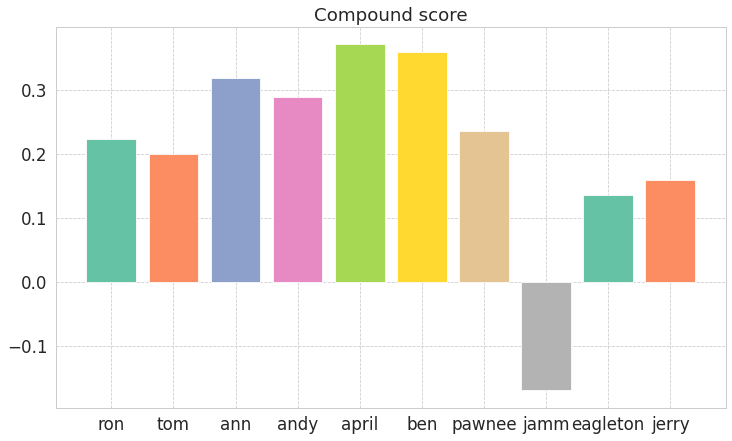

In [ ]:
x_coord = [l[0] for l in scores]
y_coord = [l[1] for l in scores]

sns.set_context("paper", font_scale = 1.9,) 
sns.set_style("whitegrid",rc = {'grid.linestyle': '--'})

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 7))
ax = plt.bar(x_coord, y_coord, color = plt.get_cmap('Set2').colors)
plt.title('Compound score')
plt.savefig("/content/drive/My Drive/Labo de datos/Wordclouds/Midiendo el amor.png")
plt.show()
